# CLIMB+CLIFF at on a simulated AML dataset 

Here we used deconvoluted cell-type proportions and deconvoluted expression at high-resolution yielded by CLIMB, as input for CLIFF. CLIFF then output a prediction of cell-type drug sensitivity for each patient, each cell-type and each drug. 

In [1]:
library(glmnet) ; library(ggplot2) ; library(reshape2)
library(CoreGx) ; library(PharmacoGx) ; 
library(sigmoid); library(ComplexHeatmap) ; library(circlize)
library(ggrepel); library(ggpmisc); library(ramify)
library(RColorBrewer) ; library(ggpubr)
# We load CLIMB / CLIFF library
library(climb) ; library(cliff)

Loading required package: Matrix

Loaded glmnet 4.1-7

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colC

In [ ]:
# update CLIFF
detach("package:climb", unload=TRUE)
devtools::install_github('alexdray86/climb', force=T)
library(climb)

In [152]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_p = read.csv(paste0(odir, '/climb_prop.csv'), row.names='X')[,colnames(true_p)]
    #climb_dw_p = read.csv(paste0(odir, '/climb_dw_prop.csv'), row.names='X')[,colnames(true_p)]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,colnames(true_p)]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,colnames(true_p)]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,colnames(true_p)]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,colnames(true_p)]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,colnames(true_p)]
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture')[,colnames(true_p)]
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_p), as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_p) ; true_prop_rows = rownames(true_p)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}   
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
}                                                                                                     ## Generate cell-type drug sensitivity as raw values for 7 doses
generate_celltype_drug_sensitivity <- function(low_decay = c('Monolike', 'Mono', 'ProMonolike'),
                                               high_decay = c('HSC', 'HSClike', 'Prog', 'Proglike'),
                                               props, signal_to_noise_ratio = 20){
    celltypes = colnames(props)
    celltype_sensitivity = matrix(0,length(celltypes),7)
    decays = list()
    for(k in 1:length(celltypes)){
        ct = celltypes[k]
        if(ct %in% low_decay){
            set.seed(k)
            decays[[k]] = runif(1,0.7,1.0)
        } else if(ct %in% high_decay) {
            set.seed(k)
            decays[[k]] = runif(1,6.0,8.0)
        } else  {
            set.seed(k)
            decays[[k]] = runif(1,1.2,2.2)
        }

        for(d in 1:7){
            celltype_sensitivity[k,d] = 1/(1 + exp(decays[[k]]*d - 8))
        }
    }
    decays = num(decays)
    ### Add random noise
    Signal = celltype_sensitivity
    Noise = randn(nrow(celltype_sensitivity),ncol(celltype_sensitivity))
    Signal_Power = sum(abs(Signal)*abs(Signal))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
    Noise_Power = sum(abs(Noise)*abs(Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
    Initial_SNR = 10*(log10(Signal_Power/Noise_Power));
    K = (Signal_Power/Noise_Power)*10^(-signal_to_noise_ratio/10)
    New_Noise = sqrt(K)*Noise
    New_Noise_Power = sum(abs(New_Noise)*abs(New_Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity))
    New_SNR = 10*(log10(Signal_Power/New_Noise_Power))
    Noisy_Signal = Signal + New_Noise;
    Noisy_Signal[Noisy_Signal < 0.0] = 0.0
    Noisy_Signal[Noisy_Signal > 1.0] = 1.0
    ## Reformat and returnk
    celltype_sensitivity = Noisy_Signal
    rownames(celltype_sensitivity) = celltypes
    colnames(celltype_sensitivity) = c(1:7)
    celltype_sensitivity = data.frame(celltype_sensitivity)
    celltype_sensitivity$sample = rownames(celltype_sensitivity)
    colnames(celltype_sensitivity) = gsub('X', 'd', colnames(celltype_sensitivity))
    melt_celltype_sensitivity = melt(celltype_sensitivity)
    celltype_sensitivity_auc = aggregate(melt_celltype_sensitivity$value, list(melt_celltype_sensitivity$sample), computeAUC_)
    colnames(celltype_sensitivity_auc) = c('sample', 'auc')
    rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample
    return(list(as.matrix(celltype_sensitivity[,-8]),celltype_sensitivity_auc))
}

generate_bulk_drug_sensitivity <- function(celltype_ds, props){
    all_patients = rownames(props)
    celltypes = colnames(props)
    bulk_survivals = list()
    tab_ct = props*5000
    set.seed(1)
    for(n in 1:length(all_patients)){
        this_patient = rownames(props)[n]
        celltype_sensitivity_1p = matrix(0,length(celltypes),7)
        tab_ct_1p = tab_ct[n,]
        counts  = tab_ct[n,]
        for(k in 1:length(celltypes)){
            counts_k  = counts[k]
            for(d in 1:7){
                celltype_sensitivity_1p[k,d] = num(round(counts_k*celltype_ds[k,d]))
            }
        }
        rownames(celltype_sensitivity_1p) = celltypes
        colnames(celltype_sensitivity_1p) = c(1:7)
        celltype_sensitivity_1p_n = apply(celltype_sensitivity_1p, 2, function(x) x/tab_ct_1p)
        celltype_sensitivity_1p_n[is.na(celltype_sensitivity_1p_n)] <- 0
        bulk_sensitivity = colSums(celltype_sensitivity_1p) / sum(tab_ct_1p)
        bulk_survivals[[n]] = bulk_sensitivity
    }
    bulk_drug_sensitivity = do.call(rbind, bulk_survivals)
    rownames(bulk_drug_sensitivity) = all_patients
    bulk_drug_sensitivity = data.frame(bulk_drug_sensitivity)
    bulk_drug_sensitivity$sample = rownames(bulk_drug_sensitivity)
    colnames(bulk_drug_sensitivity) = gsub('X', 'd', colnames(bulk_drug_sensitivity))
    melt_drug_sensitivity_data = melt(bulk_drug_sensitivity)                                    
    drug_sensitivity_auc = aggregate(melt_drug_sensitivity_data$value, list(melt_drug_sensitivity_data$sample), computeAUC_)
    colnames(drug_sensitivity_auc) = c('sample', 'auc')
    rownames(drug_sensitivity_auc) = drug_sensitivity_auc$sample
    drug_sensitivity_auc = drug_sensitivity_auc[order(num(drug_sensitivity_auc$sample)),]
    return(list(bulk_drug_sensitivity, drug_sensitivity_auc))
}
# We use same drug doses as in beatAML
doses = c(0.0137, 0.0412, 0.1235, 0.3704, 1.1111, 3.3333, 10.0)
computeAUC_ = function(viability){
    # computeAUC returns AUC related to (1-viability), we thus use (1-x)
    computeAUC(doses, viability, viability_as_pct=FALSE, area.type = 'Fitted', trunc = FALSE, verbose = FALSE)
}      
                                          
## Parameters to build 10 simulations:
list_low_decays = list(c('Monolike', 'Mono', 'ProMonolike'), c('HSClike', 'HSC', 'Proglik', 'Prog'),
                       c('GMP', 'GMPlike'), c('cDC-like', 'cDC'), c('HSC-like'), c('Monolike'), 
                       c('T'), c('HSC'), c('Proglike', 'Prog'), c('ProMonolike', 'T', 'GMP'))
list_high_decays = list(c('HSClike', 'HSC', 'Proglik', 'Prog'), c('Monolike', 'Mono', 'ProMonolike'), 
                       c('cDC-like', 'cDC'), c('HSC-like'), c('GMP', 'GMPlike'), c('HSC'),
                        c('Proglike', 'HSClike'), c('T'), c('T','CTL', 'GMP'), c('HSC','HSClike','Proglike'))

## Launch CLIMB to deconvolute simulated data

In [119]:
# Load single-cell reference dataset
sc.es = readRDS('data/pseudobulks_climb/AML_vangalen_sc_es.RDS')

In [120]:
celltype_names = reformat_celltypes(levels(sc.es$cellType))
sc.es$cellType = reformat_celltypes(sc.es$cellType)

In [124]:
# Load BeatAML bulk samples
bulk.es = readRDS("data/simulation_aml/sim200_bulk_es.RDS")

In [12]:
# Load simulated drug sensitivity data
drug_sensitivity_data = read.csv('data/simulation_aml/bulk_drug_sensitivity.csv', row.names = 'X')
head(drug_sensitivity_data)

,X1,X2,X3,X4,X5,X6,X7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9278,0.7384,0.7042,0.5712,0.3622,0.2400,0.1872
2,0.9030,0.6358,0.6038,0.4832,0.2964,0.1934,0.1460
3,0.8836,0.5582,0.5274,0.4188,0.2666,0.1780,0.1340
4,0.9192,0.6932,0.6614,0.5418,0.3722,0.2750,0.2196
5,0.8936,0.6082,0.5776,0.4644,0.3014,0.2134,0.1690
6,0.8944,0.6150,0.5860,0.4776,0.3216,0.2356,0.1832


In [13]:
drug_sensitivity_data$sample = rownames(drug_sensitivity_data)
colnames(drug_sensitivity_data) = gsub('X', 'd', colnames(drug_sensitivity_data))
melt_drug_sensitivity_data = melt(drug_sensitivity_data)                                
drug_sensitivity_auc = aggregate(melt_drug_sensitivity_data$value, list(melt_drug_sensitivity_data$sample), computeAUC_)
colnames(drug_sensitivity_auc) = c('sample', 'auc')
rownames(drug_sensitivity_auc) = drug_sensitivity_auc$sample
drug_sensitivity_auc = drug_sensitivity_auc[order(num(drug_sensitivity_auc$sample)),]

Using sample as id variables



In [14]:
head(drug_sensitivity_auc)

,sample,auc
,<chr>,<dbl>
1,1,0.4667580
2,2,0.5394231
3,3,0.5867761
4,4,0.4774994
5,5,0.5468098
6,6,0.5339559


Repeat the operation for ground truth cell-type drug sensitivity

In [284]:
# Load simulated drug sensitivity data
celltype_sensitivity_data = read.csv('data/simulation_aml/celltype_drug_sensitivity.csv', row.names = 'X')
celltype_sensitivity_data$sample = rownames(celltype_sensitivity_data)
colnames(celltype_sensitivity_data) = gsub('X', 'd', colnames(celltype_sensitivity_data))
melt_celltype_sensitivity_data = melt(celltype_sensitivity_data)
celltype_sensitivity_auc = aggregate(melt_celltype_sensitivity_data$value, list(melt_celltype_sensitivity_data$sample), computeAUC_)
colnames(celltype_sensitivity_auc) = c('sample', 'auc')
rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample
celltype_sensitivity_auc = celltype_sensitivity_auc[order(num(celltype_sensitivity_auc$sample)),]
head(celltype_sensitivity_auc)

Using sample as id variables

Warning message in num(celltype_sensitivity_auc$sample):
“NAs introduced by coercion”


,sample,auc
,<chr>,<dbl>
CTL,CTL,0.26794414
GMP,GMP,0.32344824
GMPlike,GMPlike,0.41544469
HSC,HSC,0.97014284
HSClike,HSClike,0.93556715
Mono,Mono,0.04455163


In [125]:
### RUN CLIMB in expression mode to deconvolute proportions + high-resolution cell-type expression ### 

## WARNING: This takes around 8-10 hours to run ##
climb_out = climb(sc.es, bulk.es, mode='expression', cancer_pattern = 'like')
saveRDS(climb_out, 'data/simulation_aml/climb_out_expression_sim200.RDS')

EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB

7955 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

Cell-type abundance prediction done. 

Starting high-resolution expression deconvolution

High-Resolution expression prediction: 1000 genes processed...

High-Resolution expression prediction: 2000 genes processed...

High-Resolution expression prediction: 3000 genes processed...

High-Resolution expression prediction: 4000 genes processed...

High-Resolution expression prediction: 5000 genes processed...

High-Resolution expression prediction: 6000 genes processed...

High-Resolution expression prediction: 7000 genes processed...



In [175]:
### Load pre-processed deconvoluted CLIMB's proportions and expression
climb_out = readRDS('data/simulation_aml/climb_out_expression_sim200.RDS')

In [176]:
climb_prop = climb_out$props

In [127]:
### Load proportions from other deconvolution methods
all_props = load_all_props('data/simulation_aml/tables_3/', include_cibersortx = F)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [158]:
bulk.es = bulk.es[dimnames(climb_out$expr.highres)[[2]],]
true_proportions = pData(bulk.es)

## Generate one single simulation

In [177]:
climb_prop = climb_out$props
rownames(climb_prop) = 1:200

# Generate simulated cell-type drug sensitivity
out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[1]], 
                                           high_decay = list_high_decays[[1]], climb_prop)
celltype_sensitivity = out_1[[1]]
celltype_sensitivity_auc = out_1[[2]]

# Generate bulk drug sensitivity
bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
bulk_drug_sensitivity_raw = bulk_out_[[1]]
bulk_drug_sensitivity = bulk_out_[[2]]

Using sample as id variables

Using sample as id variables



## Launch CLIFF pipeline

In [178]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=10)
        
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

## CLIFF in overall mode

In [179]:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5



[1] 0.03749174

[1] 0.5932263

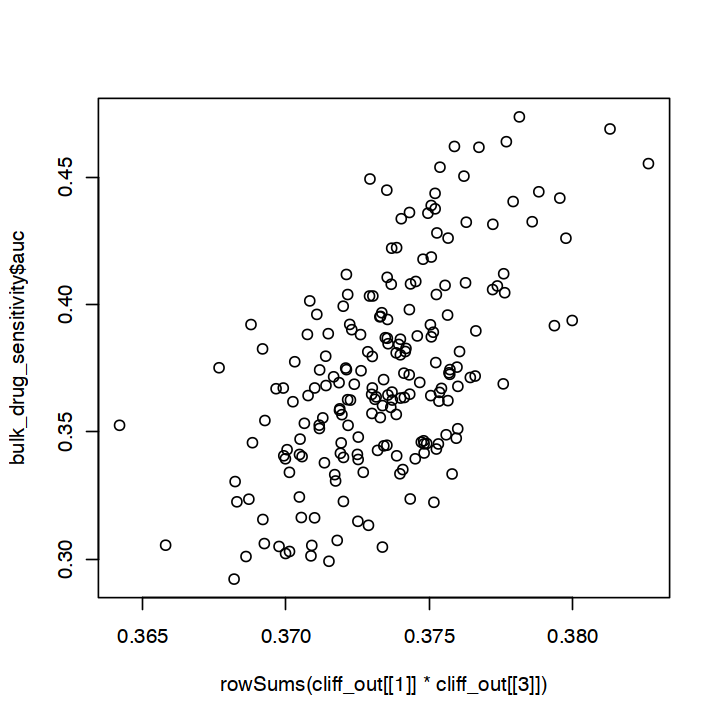

In [180]:
# PCC at bulk level
options(repr.plot.width = 6, repr.plot.height = 6)
rmse(rowSums(cliff_out[[1]] * cliff_out[[3]]), bulk_drug_sensitivity$auc)
cor(rowSums(cliff_out[[1]] * cliff_out[[3]]), bulk_drug_sensitivity$auc)
plot(rowSums(cliff_out[[1]] * cliff_out[[3]]), bulk_drug_sensitivity$auc)

In [181]:
celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
pred_celltype_sensitivity = colMeans(cliff_out[[1]])
cliff_highres = cliff_out[[1]]
colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)

[1] 0.7

[1] 0.2553544

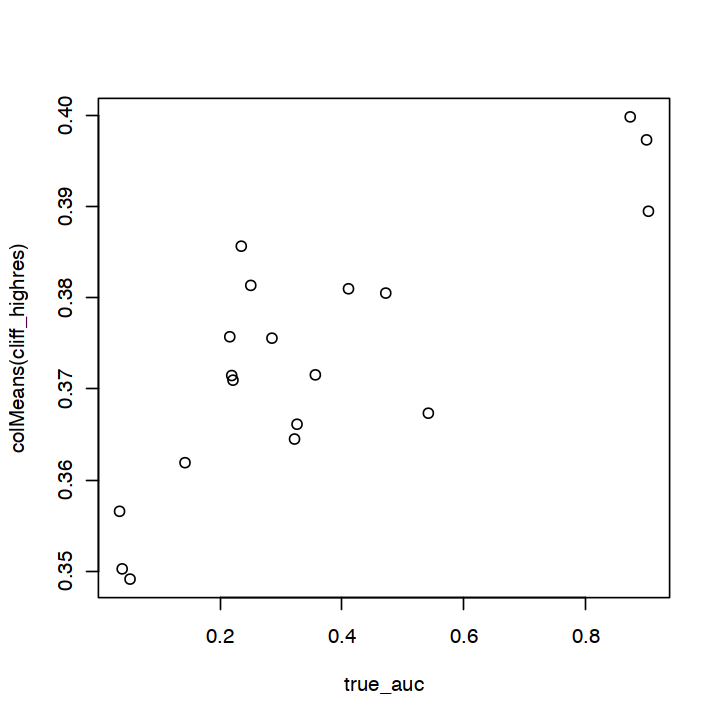

In [182]:
## PCC at cell-type level
options(repr.plot.width = 6, repr.plot.height = 6)

cor_cliff_overall = cor(true_auc, colMeans(cliff_highres), method = 'spearman')
cor_cliff_overall
rmse_cliff_overall = rmse(true_auc, colMeans(cliff_highres))
rmse_cliff_overall

plot(true_auc, colMeans(cliff_highres))

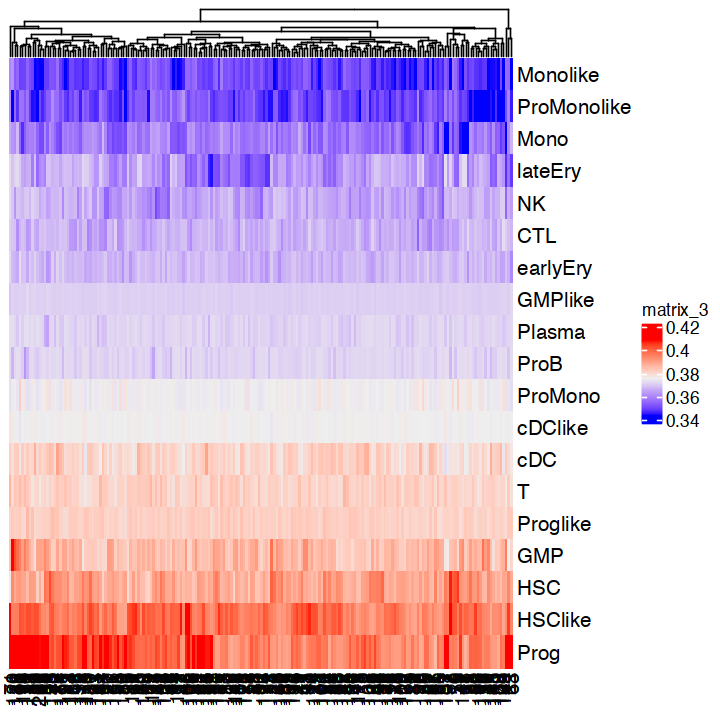

In [183]:
Heatmap(t(cliff_highres[,order(colMeans(cliff_highres))]), cluster_rows = F)

## CLIFF in high-resolution mode

In [184]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=500)
        
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

In [185]:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres', regularization='L2')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5



In [188]:
celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
pred_celltype_sensitivity = colMeans(cliff_out[[1]])
cliff_highres = cliff_out[[1]]
colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)

[1] 0.2632756

[1] 0.7808069

[1] 0.2632756

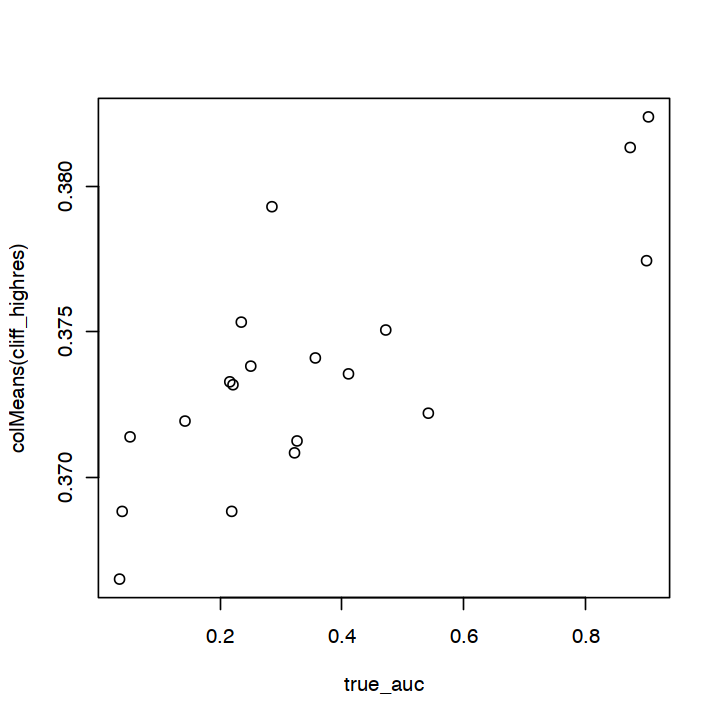

In [189]:
## PCC at cell-type level
rmse(true_auc, colMeans(cliff_highres))
cor_cliff_highres = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
cor_cliff_highres
rmse_cliff_highres = rmse(true_auc, colMeans(cliff_highres))
rmse_cliff_highres

options(repr.plot.width = 6, repr.plot.height = 6)
plot(true_auc, colMeans(cliff_highres))

## Positive control: CLIFF with true proportions and true expression

In [190]:
true_expression = readRDS('data/simulation_aml/sim200_celltype_expression.RDS')

In [191]:
dimnames(true_expression)[[1]] = 1:200 
dimnames(true_expression)[[2]] = rownames(bulk.es)
dimnames(true_expression)[[3]] = colnames(pData(bulk.es))

In [192]:
true_proportions = read.csv('data/simulation_aml/simulated_prop.csv', row.names='X')

In [193]:
climb_true = climb_out
climb_true$expr.highres = true_expression
climb_true$props = as.matrix(true_proportions)

In [194]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=500)
        
# Subset CLIMB output
climb_res.filt = climb_true
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = colMeans(climb_res.filt$expr.highres[,sel.genes,], dim=1)

In [195]:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 8



In [196]:
celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
pred_celltype_sensitivity = colMeans(cliff_out[[1]])
cliff_highres = cliff_out[[1]]
colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)

[1] 0.9457588

[1] 0.2325502

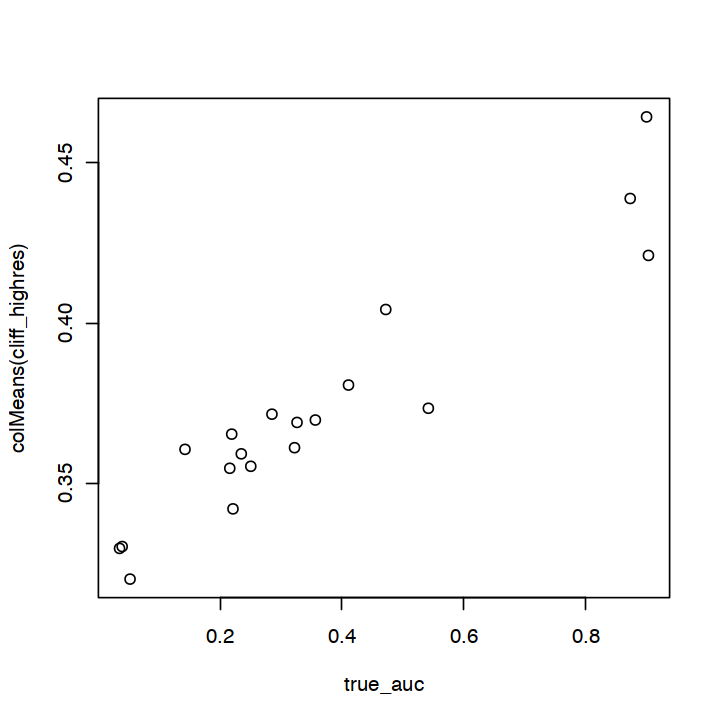

In [197]:
## PCC at cell-type level
options(repr.plot.width = 6, repr.plot.height = 6)

cor_cliff_overall = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
cor_cliff_overall
rmse_cliff_overall = rmse(true_auc, colMeans(cliff_highres))
rmse_cliff_overall

plot(true_auc, colMeans(cliff_highres))

## Karakelsar et al. Approach: linear regression with MuSiC proportions

In [200]:
all_coefs_linreg = coef(glmnet(all_props$MuSiC, bulk_drug_sensitivity$auc, 
                               lambda=0, lower.limit=0, upper.limit=1))
coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]

cor_karak = cor(celltype_sensitivity_auc$auc, coef_linreg)
cor_karak
rmse_karak = rmse(true_auc, coef_linreg)
rmse_karak

[1] 0.7362135

[1] 0.207404

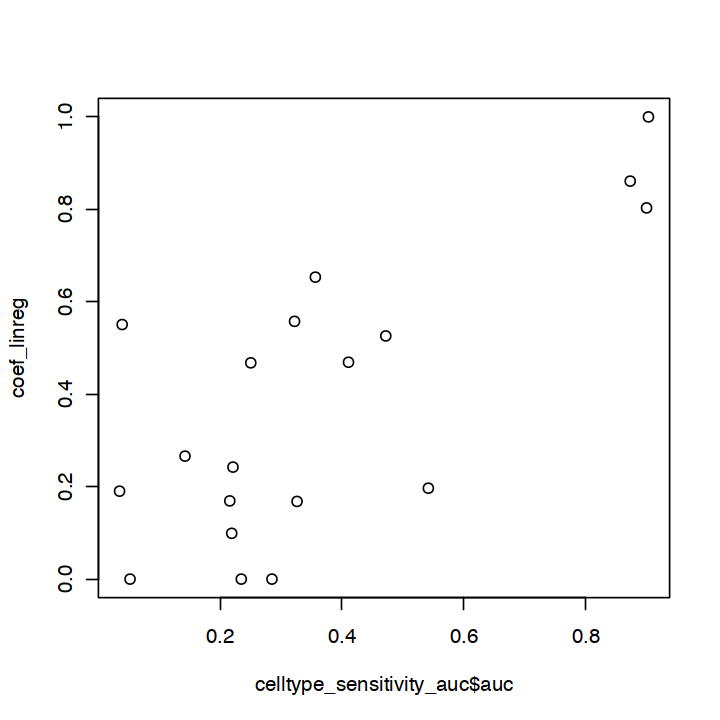

In [201]:
plot(celltype_sensitivity_auc$auc, coef_linreg)

## Bottomly et al. approach: PC1 made from Van Galen signatures

We use Van Galen signatures for the 6 cancer cell-types and define signatures for the other cell-type with Seurat `FindMarkers`. 

In [202]:
library(Seurat)
sc.srt <- CreateSeuratObject(counts = exprs(sc.es), project = "vg", min.cells = 3, min.features = 200)
Idents(object = sc.srt) <- sc.es$cellType
sc.srt <- NormalizeData(sc.srt)
sc.srt <- FindVariableFeatures(sc.srt, selection.method = "vst", nfeatures = 2000)
sc.srt <- ScaleData(sc.srt)

Centering and scaling data matrix



In [203]:
celltype_names = as.character(unique(sc.es$cellType))
celltype_names = celltype_names[!grepl('like',celltype_names)]
markers_l = list() ; markers_top50_l = list()
for(k in 1:length(celltype_names)){
    this_celltype = celltype_names[k]
    message(this_celltype)
    markers_l[[k]] = FindMarkers(sc.srt, ident.1=this_celltype)
    markers_top50_l[[k]] = rownames(head(markers_l[[k]], 50))
}
celltype_markers = unique(do.call(c,markers_top50_l))

GMP

Mono

Prog

cDC

HSC

ProMono

earlyEry

CTL

T

Plasma

ProB

NK

lateEry



In [204]:
marker_genes = do.call(cbind,markers_top50_l)
colnames(marker_genes) = celltype_names

In [205]:
vangalen_sign = read.csv('data/aml_3cohorts/cancer_cell_type_signature.csv')

In [206]:
colnames(vangalen_sign) = gsub('\\.','',colnames(vangalen_sign))

In [207]:
all_marker_genes = cbind(vangalen_sign, marker_genes)
colnames(all_marker_genes) = gsub('Monocytelike', 'Monolike', gsub('Promonolike', 'ProMonolike', gsub('Progenitorlike', 'Proglike', colnames(all_marker_genes))))

In [208]:
all(colnames(all_marker_genes) %in% colnames(pData(bulk.es)))

[1] TRUE

In [209]:
all_marker_genes_ = all_marker_genes[1:10,]

In [210]:
all_celltypes = colnames(all_marker_genes_)
cor_per_celltype = list()
for(k in 1:length(all_celltypes)){
    this_celltype = all_celltypes[k]
    bulk_expr_ct = exprs(bulk.es)[rownames(bulk.es) %in% all_marker_genes_[,k],]
    bulk_logcpm_ct = log2(1e6*t(t(bulk_expr_ct) / colSums(bulk_expr_ct))+1)
    colsums = colSums(bulk_logcpm_ct)
    prcomp.out = prcomp(t(bulk_logcpm_ct))
    pc1_ct = prcomp.out$x[,1]
    # if it positively correlated, we keep it as it is. Otherwise, we inverse the sign
    if( cor(pc1_ct, colsums) < 0 ){
        pc1_ct = pc1_ct*-1
    }
    #cor_per_celltype[[k]] = cor(pc1_ct, drug_sensitivity_auc$auc)
}

In [211]:
options(repr.plot.width = 6, repr.plot.height = 6)
#plot(num(cor_per_celltype), num(celltype_sensitivity_auc[all_celltypes,]$auc))

In [212]:
cor_bottomly = cor(num(cor_per_celltype), num(celltype_sensitivity_auc[all_celltypes,]$auc))
rmse_bottomly = rmse(num(cor_per_celltype), num(celltype_sensitivity_auc[all_celltypes,]$auc))

ERROR: Error in cor(num(cor_per_celltype), num(celltype_sensitivity_auc[all_celltypes, : incompatible dimensions


In [ ]:
all_celltypes = colnames(all_marker_genes_)
all_pc1s = list()
for(k in 1:length(all_celltypes)){
    this_celltype = all_celltypes[k]
    bulk_expr_ct = exprs(bulk.es)[rownames(bulk.es) %in% all_marker_genes_[,k],]
    bulk_logcpm_ct = log2(1e6*t(t(bulk_expr_ct) / colSums(bulk_expr_ct))+1)
    colsums = colSums(bulk_logcpm_ct)
    prcomp.out = prcomp(t(bulk_logcpm_ct))
    pc1_ct = prcomp.out$x[,1]
    # if it positively correlated, we keep it as it is. Otherwise, we inverse the sign
    if( cor(pc1_ct, colsums) < 0 ){
        pc1_ct = pc1_ct*-1
    }
    all_pc1s[[k]] = pc1_ct
}

In [ ]:
all_PC1s = do.call(cbind,all_pc1s)
colnames(all_PC1s) = all_celltypes
#all_PC1s = all_PC1s[,celltype_sensitivity_auc$sample]

In [ ]:
colnames(climb_prop) = reformat_celltypes(colnames(climb_prop))

In [ ]:
all_PC1s = all_PC1s[,colnames(climb_prop)]

## Generate 10 simulations 

These ten simulations are stored in RDS object and can be directly loaded on next cell!

In [15]:
climb_prop = climb_out$props 
true_proportions = pData(bulk.es)
all_celltype_auc = list() ; all_bulk_auc = list()
for(i in 1:10){ # 10 different simulations
    # Generate cell-type drug sensitivity
    out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[i]], 
                                               high_decay = list_high_decays[[i]], climb_prop)
    celltype_sensitivity = out_1[[1]]
    celltype_sensitivity_auc = out_1[[2]]
    all_celltype_auc[[i]] = celltype_sensitivity_auc
    
    # Generate bulk drug sensitivity
    bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
    bulk_drug_sensitivity_raw = bulk_out_[[1]]
    bulk_drug_sensitivity = bulk_out_[[2]]
    all_bulk_auc[[i]] = bulk_drug_sensitivity
}

celltype_auc = do.call(cbind,all_celltype_auc)
celltype_auc = celltype_auc[,grepl('auc', colnames(celltype_auc))]

colnames(celltype_auc) = paste0('simulation_', 1:10)

celltype_auc = t(celltype_auc)

options(repr.plot.width = 6, repr.plot.height = 4)
h <- Heatmap(celltype_auc, show_column_dend = F, name='AUC')
row_ord = row_order(h)
#pdf('results/fig5/heatmap_10simulation_celltype_auc.pdf', width=6, height=4) ; h ; dev.off()
h

bulk_auc = do.call(cbind,all_bulk_auc)
bulk_auc = bulk_auc[,grepl('auc', colnames(bulk_auc))]

bulk_auc = t(bulk_auc)
rownames(bulk_auc) = paste0('simulation_', 1:10)

options(repr.plot.width = 8, repr.plot.height = 3)
h <- Heatmap(bulk_auc, show_column_dend = F, show_column_names = F,  name='AUC')
#pdf('results/fig5/heatmap_10simulation_bulk_auc.pdf', width=8, height=3) ; h ; dev.off()
h

saveRDS(celltype_auc, 'results/fig5/celltype_auc.RDS')
saveRDS(bulk_auc, 'results/fig5/bulk_auc.RDS')

## Run 10 simulations and perform deconvolution with different methods

In [213]:
celltype_auc = readRDS('results/fig5/celltype_auc.RDS')
bulk_auc = readRDS('results/fig5/bulk_auc.RDS')

In [214]:
climb_prop = climb_out$props
rownames(climb_prop) = 1:200
cor_cliff_overall_l = list() ; rmse_cliff_overall_l = list()
cor_cliff_highres_l = list() ; rmse_cliff_highres_l = list()
cor_karakhelsar_l = list() ; rmse_karakhelsar_l = list()
cor_bottomly_l = list() ; rmse_bottomly_l = list()
all_true_auc = list() ; all_cliff_overall_auc = list()
for(i in 1:10){ # 10 different simulations
    # Generate cell-type drug sensitivity
    true_auc = celltype_auc[i,]
    celltype_sensitivity_auc = data.frame(sample=colnames(celltype_auc), auc=num(celltype_auc[i,]))
    rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample 
    
    # Generate bulk drug sensitivity
    drug_data = bulk_auc[i,]
    bulk_drug_sensitivity = data.frame(sample=as.character(1:200), auc=num(drug_data))
    
    # Feature Selection 
    bulk_mat = t(exprs(bulk.es))
    #drug_data = bulk_drug_sensitivity$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=50)
    # Subset CLIMB output
    climb_res.filt = climb_out
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
    
    # Run CLIFF-overall:
    cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')
    celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
    rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
    pred_celltype_sensitivity = colMeans(cliff_out[[1]])
    cliff_highres = cliff_out[[1]]
    colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
    cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
    true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
    cor_cliff_overall_l[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
    message(paste0('CLIFF-overall PCC: ', cor_cliff_overall_l[[i]]))
    rmse_cliff_overall_l[[i]] = rmse(true_auc, colMeans(cliff_highres))
    message(paste0('CLIFF-overall RMSE: ', rmse_cliff_overall_l[[i]]))
    all_true_auc[[i]] = true_auc
    all_cliff_overall_auc[[i]] = colMeans(cliff_highres)    

    # Feature Selection 
    bulk_mat = t(exprs(bulk.es))
    drug_data = bulk_drug_sensitivity$auc
    sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=500)
    # Subset CLIMB output
    climb_res.filt = climb_out
    climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
    climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
    
    # Run CLIFF-highres
    cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres', regularization='L2')
    celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
    rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
    pred_celltype_sensitivity = colMeans(cliff_out[[1]])
    cliff_highres = cliff_out[[1]]
    colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
    cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
    true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
    cor_cliff_highres_l[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
    message(paste0('CLIFF-highres PCC: ', cor_cliff_highres_l[[i]]))
    rmse_cliff_highres_l[[i]] = rmse(true_auc, colMeans(cliff_highres))
    message(paste0('CLIFF-highres RMSE: ', rmse_cliff_highres_l[[i]]))
    
    # Run Karakhelsar (Linear Regression with MuSiC props):
    all_coefs_linreg = coef(glmnet(all_props$MuSiC, bulk_drug_sensitivity$auc, 
                               lambda=0, lower.limit=0, upper.limit=1))
    coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]
    cor_karakhelsar_l[[i]] = cor(celltype_sensitivity_auc$auc, coef_linreg)
    message(paste0('Karakhelsar PCC: ', cor_karakhelsar_l[[i]]))
    rmse_karakhelsar_l[[i]] = rmse(true_auc, coef_linreg)
    message(paste0('Karakhelsar RMSE: ', rmse_karakhelsar_l[[i]]))
    
    # Run Bottomly approach (PC1 from van galen signatures - requires to load van galen signatures):
    bottomly_ct_drug_sens = cor(all_PC1s, bulk_drug_sensitivity$auc)
    cor_bottomly_l[[i]] = cor(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
    message(paste0('Bottomly PCC: ', cor_bottomly_l[[i]]))
    rmse_bottomly_l[[i]] = rmse(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
    message(paste0('Bottomly RMSE: ', rmse_bottomly_l[[i]]))
}

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.814060409552771

CLIFF-overall RMSE: 0.271200304436982

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.777490737529661

CLIFF-highres RMSE: 0.279270176659335

Karakhelsar PCC: 0.70455037055721

Karakhelsar RMSE: 0.233495711678156

Bottomly PCC: 0.597980372319563

Bottomly RMSE: 0.414014127261966

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB 

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.74983487592526

CLIFF-highres RMSE: 0.287553036108722

Karakhelsar PCC: 0.79001984300321

Karakhelsar RMSE: 0.202688660285613

Bottomly PCC: 0.764053985880518

Bottomly RMSE: 0.450214359769888



In [215]:
all_cors = do.call(cbind, list(cor_cliff_overall_l, cor_cliff_highres_l, cor_karakhelsar_l, cor_bottomly_l))
all_cors = data.frame(t(apply(all_cors, 1, num)))

No id variables; using all as measure variables



pdf 
  2

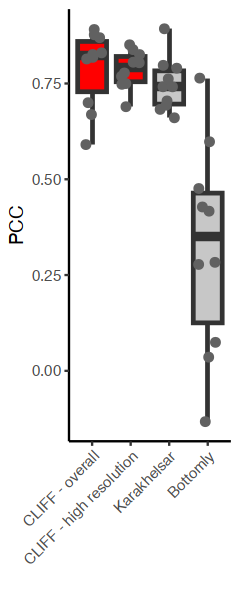

In [217]:
colnames(all_cors) = c('CLIFF - overall', 'CLIFF - high resolution', 'Karakhelsar', 'Bottomly')
rownames(all_cors) = 1:10
melt_cors = melt(all_cors)
colnames(melt_cors) = c('method', 'PCC')
order_levels = order(aggregate(melt_cors$PCC, list(melt_cors$method), mean)$x)
melt_cors$method = factor(melt_cors$method, levels=levels(melt_cors$method)[rev(order_levels)])
options(repr.plot.width = 2, repr.plot.height = 5)
g <- ggplot(melt_cors, aes(x=method, y=PCC, fill=method)) + geom_boxplot(size=1) + 
    geom_jitter(size=2, color='grey38',width=0.25, height=0) +theme_classic() +
    scale_fill_manual(values = ifelse(grepl('CLIFF', levels(melt_cors$method)), 'red', 'grey78'))+
    scale_color_manual(values = ifelse(grepl('CLIFF', levels(melt_cors$method)), 'red', 'grey78'))+
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('') #+ ylim(c(0,1.0))
pdf('results/fig5/boxplot_cliff_vs_karak_bottomly_PCC_1sim.pdf', width=2, height=5) ; g ; dev.off()
g

In [233]:
apply(all_cors, 2, median)

CLIFF - overall CLIFF - high resolution             Karakhelsar 
              0.8219504               0.7908499               0.7414288 
               Bottomly 
              0.3499762

No id variables; using all as measure variables



pdf 
  2

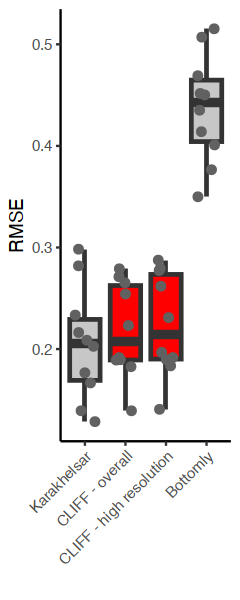

In [218]:
all_rmses = do.call(cbind, list(rmse_cliff_overall_l, rmse_cliff_highres_l, rmse_karakhelsar_l, rmse_bottomly_l))
all_rmses = data.frame(t(apply(all_rmses, 1, num)))
colnames(all_rmses) = c('CLIFF - overall', 'CLIFF - high resolution', 'Karakhelsar', 'Bottomly')
rownames(all_rmses) = 1:10
melt_rmses = melt(all_rmses)
colnames(melt_rmses) = c('method', 'RMSE')
order_levels = order(aggregate(melt_rmses$RMSE, list(melt_rmses$method), median)$x)
melt_rmses$method = factor(melt_rmses$method, levels=levels(melt_rmses$method)[order_levels])
options(repr.plot.width = 2, repr.plot.height = 5)
g <- ggplot(melt_rmses, aes(x=method, y=RMSE, fill=method)) + geom_boxplot(size=1) + 
    geom_jitter(size=2, color='grey38',width=0.25, height=0) +theme_classic() +
    scale_fill_manual(values = ifelse(grepl('CLIFF', levels(melt_rmses$method)), 'red', 'grey78'))+
    scale_color_manual(values = ifelse(grepl('CLIFF', levels(melt_rmses$method)), 'red', 'grey78'))+
    theme(legend.position="none", axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('')
pdf('results/fig5/boxplot_cliff_vs_karak_bottomly_RMSE_1sim.pdf', width=2, height=5) ; g ; dev.off()
g

In [219]:
cliff_overall_auc_mat = do.call(rbind, all_cliff_overall_auc)
rownames(cliff_overall_auc_mat) = rownames(celltype_auc)
colnames(cliff_overall_auc_mat) = colnames(celltype_auc)

## Simulation with mutation and bulk-level variability

In [220]:
generate_celltype_drug_sensitivity_highres <- function(low_decay = c('Monolike', 'Mono', 'ProMonolike'),
                                               high_decay = c('HSC', 'HSClike', 'Prog', 'Proglike'),
                                               props, signal_to_noise_ratio = 20){
    sample_names = rownames(props)
    list_results = list()
    for(n in 1:length(sample_names)){
        message(n)
        celltypes = colnames(props)
        celltype_sensitivity = matrix(0,length(celltypes),7)
        decays = list()
        for(k in 1:length(celltypes)){
            ct = celltypes[k]
            if(ct %in% low_decay){
                #set.seed(k)
                decays[[k]] = runif(1,0.7,1.0)
            } else if(ct %in% high_decay) {
                #set.seed(k)
                decays[[k]] = runif(1,6.0,8.0)
            } else  {
                decays[[k]] = runif(1,1.2,2.2)
            }

            for(d in 1:7){
                celltype_sensitivity[k,d] = 1/(1 + exp(decays[[k]]*d - 8))
            }
        }
        decays = num(decays)
        ### Add random noise
        Signal = celltype_sensitivity
        Noise = randn(nrow(celltype_sensitivity),ncol(celltype_sensitivity))
        Signal_Power = sum(abs(Signal)*abs(Signal))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
        Noise_Power = sum(abs(Noise)*abs(Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity));
        Initial_SNR = 10*(log10(Signal_Power/Noise_Power));
        K = (Signal_Power/Noise_Power)*10^(-signal_to_noise_ratio/10)
        New_Noise = sqrt(K)*Noise
        New_Noise_Power = sum(abs(New_Noise)*abs(New_Noise))/(nrow(celltype_sensitivity)*ncol(celltype_sensitivity))
        New_SNR = 10*(log10(Signal_Power/New_Noise_Power))
        Noisy_Signal = Signal + New_Noise;
        Noisy_Signal[Noisy_Signal < 0.0] = 0.0
        Noisy_Signal[Noisy_Signal > 1.0] = 1.0
        ## Reformat and returnk
        celltype_sensitivity = Noisy_Signal
        rownames(celltype_sensitivity) = celltypes
        colnames(celltype_sensitivity) = c(1:7)
        celltype_sensitivity = data.frame(celltype_sensitivity)
        celltype_sensitivity$sample = rownames(celltype_sensitivity)
        colnames(celltype_sensitivity) = gsub('X', 'd', colnames(celltype_sensitivity))
        melt_celltype_sensitivity = melt(celltype_sensitivity)
        celltype_sensitivity_auc = aggregate(melt_celltype_sensitivity$value, list(melt_celltype_sensitivity$sample), computeAUC_)
        colnames(celltype_sensitivity_auc) = c('sample', 'auc')
        rownames(celltype_sensitivity_auc) = celltype_sensitivity_auc$sample
        list_results[[n]] = list(as.matrix(celltype_sensitivity[,-8]),celltype_sensitivity_auc)
    }
    return(list_results)
}

generate_bulk_drug_sensitivity_highres <- function(celltype_ds, props){
    all_patients = rownames(props)
    celltypes = colnames(props)
    bulk_survivals = list()
    tab_ct = props*5000
    set.seed(1)
    for(n in 1:length(all_patients)){
        this_patient = rownames(props)[n]
        celltype_sensitivity_1p = matrix(0,length(celltypes),7)
        tab_ct_1p = tab_ct[n,]
        counts  = tab_ct[n,]
        for(k in 1:length(celltypes)){
            counts_k  = counts[k]
            for(d in 1:7){
                celltype_sensitivity_1p[k,d] = num(round(counts_k*celltype_ds[[n]][[1]][k,d]))
            }
        }
        rownames(celltype_sensitivity_1p) = celltypes
        colnames(celltype_sensitivity_1p) = c(1:7)
        celltype_sensitivity_1p_n = apply(celltype_sensitivity_1p, 2, function(x) x/tab_ct_1p)
        celltype_sensitivity_1p_n[is.na(celltype_sensitivity_1p_n)] <- 0
        bulk_sensitivity = colSums(celltype_sensitivity_1p) / sum(tab_ct_1p)
        bulk_survivals[[n]] = bulk_sensitivity
    }
    bulk_drug_sensitivity = do.call(rbind, bulk_survivals)
    rownames(bulk_drug_sensitivity) = all_patients
    bulk_drug_sensitivity = data.frame(bulk_drug_sensitivity)
    bulk_drug_sensitivity$sample = rownames(bulk_drug_sensitivity)
    colnames(bulk_drug_sensitivity) = gsub('X', 'd', colnames(bulk_drug_sensitivity))
    melt_drug_sensitivity_data = melt(bulk_drug_sensitivity)                                    
    drug_sensitivity_auc = aggregate(melt_drug_sensitivity_data$value, list(melt_drug_sensitivity_data$sample), computeAUC_)
    colnames(drug_sensitivity_auc) = c('sample', 'auc')
    rownames(drug_sensitivity_auc) = drug_sensitivity_auc$sample
    drug_sensitivity_auc = drug_sensitivity_auc[order(num(drug_sensitivity_auc$sample)),]
    return(list(bulk_drug_sensitivity, drug_sensitivity_auc))
}
## Parameters to build 10 simulations:
list_low_decays = list(c('Monolike', 'Mono', 'ProMonolike'), c('HSClike', 'HSC', 'Proglik', 'Prog'),
                       c('GMP', 'GMPlike'), c('cDC-like', 'cDC'), c('HSC-like'), c('Monolike'), 
                       c('T'), c('HSC'), c('Proglike', 'Prog'), c('ProMonolike', 'T', 'GMP'))
list_high_decays = list(c('HSClike', 'HSC', 'Proglik', 'Prog'), c('Monolike', 'Mono', 'ProMonolike'), 
                       c('cDC-like', 'cDC'), c('HSC-like'), c('GMP', 'GMPlike'), c('HSC'),
                        c('Proglike', 'HSClike'), c('T'), c('T','CTL', 'GMP'), c('HSC','HSClike','Proglike'))

In [221]:
 # Generate cell-type drug sensitivity
out_1 = generate_celltype_drug_sensitivity_highres(high_decay = list('Monolike', 'ProMonolike'), 
                                                   low_decay = list('HSClike', 'Proglike'),
                                                   true_proportions[1:100,])

1

Using sample as id variables

2

Using sample as id variables

3

Using sample as id variables

4

Using sample as id variables

5

Using sample as id variables

6

Using sample as id variables

7

Using sample as id variables

8

Using sample as id variables

9

Using sample as id variables

10

Using sample as id variables

11

Using sample as id variables

12

Using sample as id variables

13

Using sample as id variables

14

Using sample as id variables

15

Using sample as id variables

16

Using sample as id variables

17

Using sample as id variables

18

Using sample as id variables

19

Using sample as id variables

20

Using sample as id variables

21

Using sample as id variables

22

Using sample as id variables

23

Using sample as id variables

24

Using sample as id variables

25

Using sample as id variables

26

Using sample as id variables

27

Using sample as id variables

28

Using sample as id variables

29

Using sample as id variables

30

Using sample as id 

In [222]:
celltype_auc_sensitive = do.call(rbind, lapply(out_1, function(x) x[[2]]$auc))
colnames(celltype_auc_sensitive) = colnames(true_proportions)
rownames(celltype_auc_sensitive) = 1:100                                          

In [223]:
# Generate bulk drug sensitivity
bulk_out_sensitive = generate_bulk_drug_sensitivity_highres(out_1, true_proportions[1:100,])
bulk_out_sensitive = bulk_out_sensitive[[2]]

Using sample as id variables



In [224]:
 # Generate cell-type drug sensitivity
out_2 = generate_celltype_drug_sensitivity_highres(low_decay = list('Monolike', 'ProMonolike'), 
                                                   high_decay = list('HSClike', 'Proglike'),
                                                   true_proportions[101:200,])

1

Using sample as id variables

2

Using sample as id variables

3

Using sample as id variables

4

Using sample as id variables

5

Using sample as id variables

6

Using sample as id variables

7

Using sample as id variables

8

Using sample as id variables

9

Using sample as id variables

10

Using sample as id variables

11

Using sample as id variables

12

Using sample as id variables

13

Using sample as id variables

14

Using sample as id variables

15

Using sample as id variables

16

Using sample as id variables

17

Using sample as id variables

18

Using sample as id variables

19

Using sample as id variables

20

Using sample as id variables

21

Using sample as id variables

22

Using sample as id variables

23

Using sample as id variables

24

Using sample as id variables

25

Using sample as id variables

26

Using sample as id variables

27

Using sample as id variables

28

Using sample as id variables

29

Using sample as id variables

30

Using sample as id 

In [225]:
celltype_auc_resistant = do.call(rbind, lapply(out_2, function(x) x[[2]]$auc))
colnames(celltype_auc_resistant) = colnames(true_proportions)
rownames(celltype_auc_resistant) = 101:200                                          

In [226]:
# Generate bulk drug sensitivity
bulk_out_resistant = generate_bulk_drug_sensitivity_highres(out_2, true_proportions[101:200,])
bulk_out_resistant = bulk_out_resistant[[2]]

Using sample as id variables



In [227]:
mat_true_highres = t(rbind(celltype_auc_sensitive,celltype_auc_resistant))

In [228]:
mat_true_highres = data.frame(mat_true_highres)
rownames(mat_true_highres) = celltype_sensitivity_resistant_auc$sample
colnames(mat_true_highres) = 1:200

ERROR: Error in eval(expr, envir, enclos): object 'celltype_sensitivity_resistant_auc' not found


In [ ]:
quant = quantile(flatten(t(mat_true_highres)), probs=c(0,0.05,0.5,0.95,1))# ; quant[3] = 0.5
col_fun = colorRamp2(c(quant[1], quant[2], quant[3], quant[4], quant[5]), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))

pdf 
  2

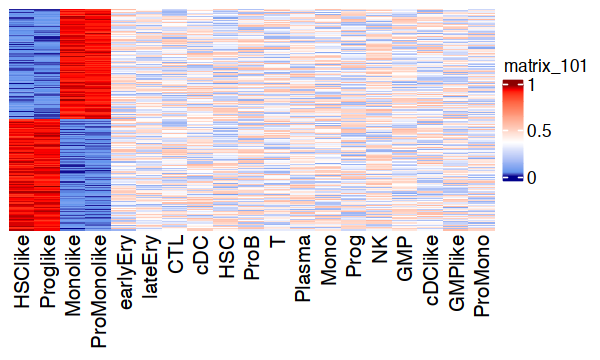

In [891]:
options(repr.plot.width = 5, repr.plot.height = 3)
h <- Heatmap(t(mat_true_highres), cluster_rows=F, show_row_names = F, show_column_dend = F,
            col=col_fun)
h <- draw(h)
row_ord = row_order(h)
col_ord = column_order(h)
#pdf('results/fig5/heatmap_highres_expression_200sim_true.pdf', width=5, height=3) ; h ; dev.off()
h

In [823]:
# We generate simulated mutation data that followed the two groups
set.seed(1)
mut.data = cbind(c(rbinom(100, 1, 0.8), rep(0,100)), c(rbinom(100, 1, 0.8), rep(0,100)),
                 c(rep(0,100), rbinom(100, 1, 0.8)), c(rep(0,100), rbinom(100, 1, 0.8)),
                 c(rbinom(100, 1, 0.4), rep(0,100)), c(rbinom(100, 1, 0.4), rep(0,100)),
                 c(rep(0,100), rbinom(100, 1, 0.4)), c(rep(0,100), rbinom(100, 1, 0.4)),
                 rbinom(200, 1, 0.4), rbinom(200, 1, 0.6))
mut.data = data.frame(mut.data)
rownames(mut.data) = 1:200
colnames(mut.data) = gsub('X', 'mut', colnames(mut.data))

In [899]:
col_fun = colorRamp2(breaks=c(0,1), colors=c("white", "grey38"))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

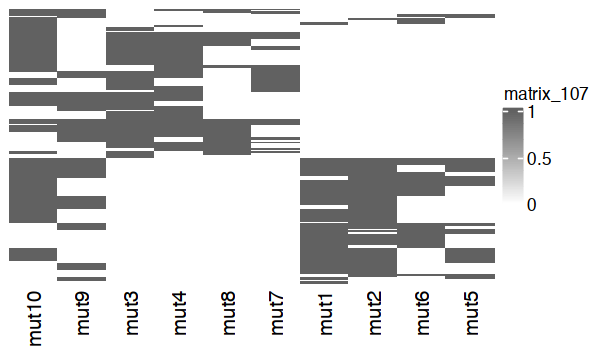

In [901]:
options(repr.plot.width = 5, repr.plot.height = 3)
h <- Heatmap(mut.data, show_row_names = F, show_column_dend = F, show_row_dend = F, col=col_fun)
pdf('results/fig5/heatmap_highres_expression_200sim_mutation.pdf', width=5, height=3) ; h ; dev.off()
h

In [825]:
bulk_drug_sensitivity = rbind(bulk_out_sensitive, bulk_out_resistant)

In [838]:
# Feature Selection 
bulk_mat = t(exprs(bulk.es))
#drug_data = bulk_drug_sensitivity$auc
sel.genes = cliff_gene_selection(bulk_mat, bulk_drug_sensitivity$auc, min.genes=10)
# Subset CLIMB output
climb_res.filt = climb_out
climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

In [839]:
# Run CLIFF-overall:
cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, mut.data, max.em.steps=200, mode = 'overall')

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 10



In [840]:
cliff_highres = cliff_out[[1]]

In [903]:
quant = quantile(flatten(cliff_highres), probs=c(0,0.05,0.5,0.95,1))# ; quant[3] = 0.5
col_fun = colorRamp2(c(quant[1], quant[2], quant[3], quant[4], quant[5]), rev(c("darkred", "red", "white", "cornflowerblue", "darkblue")))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


pdf 
  2

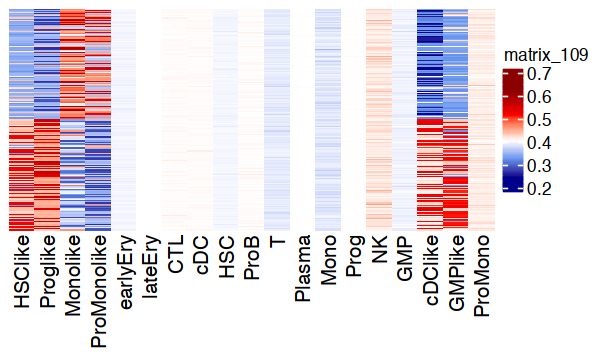

In [904]:
h<- Heatmap(cliff_highres[row_ord, col_ord], cluster_columns=F, cluster_rows = F, show_row_names = F, 
            show_column_dend = F, col=col_fun)
pdf('results/fig5/heatmap_highres_expression_200sim_cliff_pred.pdf', width=5, height=3) ; h ; dev.off()
h

pdf 
  2

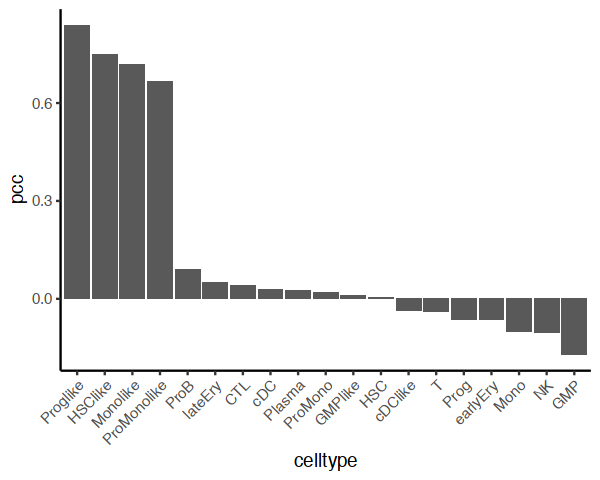

In [911]:
celltype_cor = diag(cor(cliff_highres, t(mat_true_highres)))
celltype_cor = celltype_cor[order(celltype_cor)]
df_celltype_cor = data.frame(celltype=names(celltype_cor), pcc=celltype_cor)
df_celltype_cor$type = 'others' 
df_celltype_cor[df_celltype_cor$celltype %in% c('Monolike', 'ProMonolike', 'Proglike', 'HSClike'),]$type = 'divergent'
df_celltype_cor$celltype = factor(df_celltype_cor$celltype, levels=rev(df_celltype_cor$celltype))
options(repr.plot.width = 5, repr.plot.height = 4)
g <- ggplot(df_celltype_cor, aes(x=celltype, y=pcc)) + theme_classic() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1.0, hjust=1),legend.position="none") + 
    geom_col() 
pdf('results/fig5/barplot_pcc_per_celltype_cliff_highres_200sim.pdf', width=5, height=4) ; g ; dev.off()
g

## Compare different number of genes as input

How many genes should be given as input for CLIFF ? 

In [349]:
climb_prop = climb_out$props
rownames(climb_prop) = 1:200

# Generate simulated cell-type drug sensitivity
out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[1]], 
                                           high_decay = list_high_decays[[1]], climb_prop)
celltype_sensitivity = out_1[[1]]
celltype_sensitivity_auc = out_1[[2]]

# Generate bulk drug sensitivity
bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
bulk_drug_sensitivity_raw = bulk_out_[[1]]
bulk_drug_sensitivity = bulk_out_[[2]]

Using sample as id variables

Using sample as id variables



In [113]:
min.n.genes_vec = c(1,10,25,50,100,200,500,1000)
pcc_overall_l = list() ; rmse_overall_l = list() ; n_genes = list()
pcc_highres_l = list() ; rmse_highres_l = list() ; 
pcc_overall_l2_l = list() ; rmse_overall_l2_l = list()
pcc_highres_l2_l = list() ; rmse_highres_l2_l = list() ;

for(x in 1:10){ # 10 different simulations
    # Generate cell-type drug sensitivity
    out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[x]], 
                                               high_decay = list_high_decays[[x]], climb_prop)
    celltype_sensitivity = out_1[[1]]
    celltype_sensitivity_auc = out_1[[2]]

    # Generate bulk drug sensitivity
    bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions)
    bulk_drug_sensitivity_raw = bulk_out_[[1]]
    bulk_drug_sensitivity = bulk_out_[[2]]
    
    pcc_overall = list() ; rmse_overall = list() ; 
    pcc_highres = list() ; rmse_highres = list() ; 
    pcc_overall_l2 = list() ; rmse_overall_l2 = list() ; 
    pcc_highres_l2 = list() ; rmse_highres_l2 = list() ; 

    for(i in 1:length(min.n.genes_vec)){
        n.genes = min.n.genes_vec[i]
        message(paste0('n_genes: ', n.genes))
        n_genes[[i]] = length(sel.genes)
        
        # Feature Selection 
        bulk_mat = t(exprs(bulk.es))
        drug_data = bulk_drug_sensitivity$auc
        sel.genes = cliff_gene_selection(bulk_mat, drug_data, min.genes=n.genes)
        
        # Subset CLIMB output
        climb_res.filt = climb_out
        climb_res.filt$expr.highres = climb_res.filt$expr.highres[,sel.genes,]
        climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]

        # Run CLIFF-overall:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_overall[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-overall PCC: ', pcc_overall[[i]]))
        rmse_overall[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-overall RMSE: ', rmse_overall[[i]]))

        # Run CLIFF-highres
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_highres[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-highres PCC: ', pcc_highres[[i]]))
        rmse_highres[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-highres RMSE: ', rmse_highres[[i]]))
        
        # Run CLIFF-overall with L2 reg:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall', regularization = 'L2')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_overall_l2[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-overall PCC: ', pcc_overall_l2[[i]]))
        rmse_overall_l2[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-overall RMSE: ', rmse_overall_l2[[i]]))

        # Run CLIFF-highres with L2 reg:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres', regularization = 'L2')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        pcc_highres_l2[[i]] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        message(paste0('CLIFF-highres PCC: ', pcc_highres_l2[[i]]))
        rmse_highres_l2[[i]] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-highres RMSE: ', rmse_highres_l2[[i]]))
    }
    pcc_overall_l[[x]] = num(pcc_overall) ;  rmse_overall_l[[x]] = num(rmse_overall) ; 
    pcc_highres_l[[x]] = num(pcc_highres) ;  rmse_highres_l[[x]] = num(rmse_highres) ; 
    pcc_overall_l2_l[[x]] = num(pcc_overall_l2) ;  rmse_overall_l2_l[[x]] = num(rmse_overall_l2) ; 
    pcc_highres_l2_l[[x]] = num(pcc_highres_l2) ;  rmse_highres_l2_l[[x]] = num(rmse_highres_l2) ; 
}

Using sample as id variables

Using sample as id variables

n_genes: 1

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.862921646436714

CLIFF-overall RMSE: 0.260626791943659

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.679460783437149

CLIFF-highres RMSE: 0.270680744433582

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algo

In [385]:
mat_ = data.frame(do.call(rbind,pcc_highres_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_highres = melt(mat_)
melt_highres$method = 'CLIFF-highres'
mat_ = data.frame(do.call(rbind,pcc_highres_l2_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_highres_l2 = melt(mat_)
melt_highres_l2$method = 'CLIFF-highres-L2'
mat_ = data.frame(do.call(rbind,pcc_overall_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_overall = melt(mat_)
melt_overall$method = 'CLIFF-overall'
mat_ = data.frame(do.call(rbind,pcc_overall_l2_l))
rownames(mat_) = 1:10 ; colnames(mat_) = min.n.genes_vec
melt_overall_l2 = melt(mat_)
melt_overall_l2$method = 'CLIFF-overall-L2'

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



In [387]:
melt_ = rbind(melt_highres, melt_highres_l2, melt_overall, melt_overall_l2)

In [394]:
write.csv(melt_, 'data/simulation_aml/cliff_accuracy_vs_n_genes_200sim.csv', quote=F)
melt_ = read.csv('data/simulation_aml/cliff_accuracy_vs_n_genes_200sim.csv', row.names='X')

In [398]:
melt_$variable = factor(melt_$variable, levels=unique(melt_$variable)[order(num(unique(melt_$variable)))])

pdf 
  2

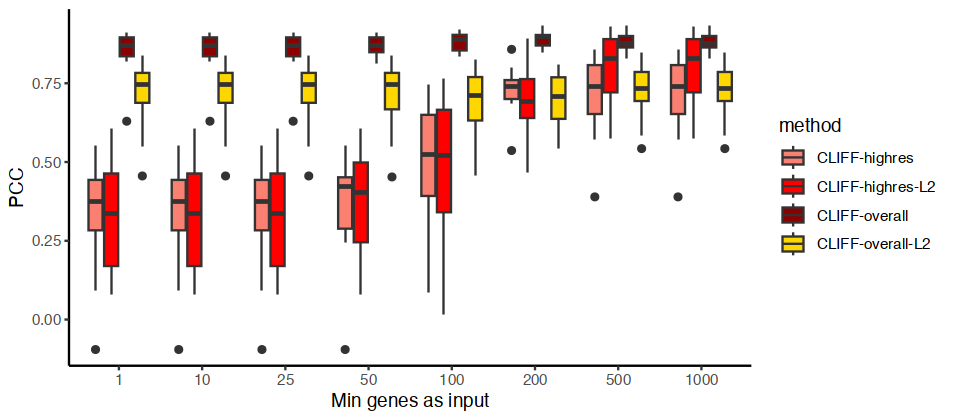

In [400]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
g <- ggplot(melt_) + geom_boxplot(aes(x=variable, y=value, fill=method)) +
    scale_fill_manual(values = c('salmon', 'red', 'darkred', 'gold')) +theme_classic() +
    xlab('Min genes as input') + ylab('PCC')
pdf('results/fig5/boxplot_cliff_accuracy_vs_n_genes_200sim.csv.pdf', width=8, height=3.5) ; g ; dev.off()
g

## Re-run bigger simulation with increasing number of bulk sample as input 

In [90]:
n_bulk_samples = c(5,10,20,30,40,50,75,100,150,200) # 10 different sample numbers
climb_prop = climb_out$props
rownames(climb_prop) = 1:200
music_prop = all_props$MuSiC
cor_cliff_overall_l = matrix(0, nrow=10, ncol=10) ; rmse_cliff_overall_l = matrix(0, nrow=10, ncol=10)
scor_cliff_overall_l = matrix(0, nrow=10, ncol=10); scor_cliff_highres_l = matrix(0, nrow=10, ncol=10)
cor_cliff_highres_l = matrix(0, nrow=10, ncol=10) ; rmse_cliff_highres_l = matrix(0, nrow=10, ncol=10)
cor_cliff_true_overall_l = matrix(0, nrow=10, ncol=10) ; rmse_cliff_true_overall_l = matrix(0, nrow=10, ncol=10)
scor_cliff_true_overall_l = matrix(0, nrow=10, ncol=10); scor_cliff_l2reg_overall_l = matrix(0, nrow=10, ncol=10)
cor_karakhelsar_l = matrix(0, nrow=10, ncol=10) ; rmse_karakhelsar_l = matrix(0, nrow=10, ncol=10)
scor_karakhelsar_l = matrix(0, nrow=10, ncol=10); scor_karakhelsar_scaden_l = matrix(0, nrow=10, ncol=10)
cor_bottomly_l = matrix(0, nrow=10, ncol=10) ; rmse_bottomly_l = matrix(0, nrow=10, ncol=10)
scor_bottomly_l = matrix(0, nrow=10, ncol=10)
ct_prop_cliff_overall_l = list() ; ct_prop_cliff_highres_l = list()
ct_prop_cliff_true_l = list() ; ct_prop_cliff_l2reg_l = list()
ct_prop_karakhelsar_l = list() ; ct_prop_karakhelsar_scaden_l = list()
ct_prop_bottomly_l = list() ; ct_prop_true_l = list()

for(j in 1:length(n_bulk_samples)){
    N = n_bulk_samples[j]
    # subset imput samples
    climb_prop.sub = climb_prop[1:N,]
    music_prop.sub = music_prop[1:N,]
    true_proportions.sub = true_proportions[1:N,]
    rownames(true_proportions.sub) = 1:N
    all_PC1s.sub = all_PC1s[1:N,]
    ct_prop_cliff_overall = list() ; ct_prop_cliff_highres = list()
    ct_prop_cliff_true = list() ; ct_prop_cliff_l2reg = list()
    ct_prop_karakhelsar = list() 
    ct_prop_bottomly = list() ; ct_prop_true = list()
    
    for(i in 1:10){ # 10 different simulations
        # Generate cell-type drug sensitivity
        out_1 = generate_celltype_drug_sensitivity(low_decay = list_low_decays[[i]], 
                                                   high_decay = list_high_decays[[i]], climb_prop.sub)
        celltype_sensitivity = out_1[[1]]
        celltype_sensitivity_auc = out_1[[2]]
        
        # Generate bulk drug sensitivity
        bulk_out_ = generate_bulk_drug_sensitivity(celltype_sensitivity, true_proportions.sub)
        bulk_drug_sensitivity_raw = bulk_out_[[1]]
        bulk_drug_sensitivity = data.frame(bulk_out_[[2]])
        
        # Feature Selection 
        bulk_mat = t(exprs(bulk.es))
        drug_data = bulk_drug_sensitivity$auc
        sel.genes = cliff_gene_selection(bulk_mat[1:N,], drug_data, min.genes=50)
        
        # Subset CLIMB output
        climb_res.filt = climb_out
        climb_res.filt$expr.highres = climb_res.filt$expr.highres[1:N,sel.genes,]
        climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
        climb_res.filt$props = climb_prop.sub
        
        # Run CLIFF-overall:
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'overall')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        cor_cliff_overall_l[j,i] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        scor_cliff_overall_l[j,i] = cor(true_auc, colMeans(cliff_highres), method = 'spearman')
        message(paste0('CLIFF-overall PCC: ', cor_cliff_overall_l[j,i]))
        rmse_cliff_overall_l[j,i] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-overall RMSE: ', rmse_cliff_overall_l[j,i]))
        ct_prop_cliff_overall[[i]] = colMeans(cliff_highres)

        # Feature Selection 
        bulk_mat = t(exprs(bulk.es))
        drug_data = bulk_drug_sensitivity$auc
        sel.genes = cliff_gene_selection(bulk_mat[1:N,], drug_data, min.genes=500)
        
        # Subset CLIMB output
        climb_res.filt = climb_out
        climb_res.filt$expr.highres = climb_res.filt$expr.highres[1:N,sel.genes,]
        climb_res.filt$expr.overall = climb_res.filt$expr.overall[sel.genes,]
        climb_res.filt$props = climb_prop.sub
        
        # Run CLIFF-highres
        cliff_out = cliff(climb_res.filt, bulk_drug_sensitivity, max.em.steps=200, mode = 'highres',
                          regularization='L2')
        celltype_sensitivity_auc$sample = gsub('-','',celltype_sensitivity_auc$sample)
        rownames(celltype_sensitivity_auc) = gsub('-','',rownames(celltype_sensitivity_auc))
        pred_celltype_sensitivity = colMeans(cliff_out[[1]])
        cliff_highres = cliff_out[[1]]
        colnames(cliff_highres) = gsub('-','',colnames(cliff_highres))
        cliff_highres = cliff_highres[,colnames(cliff_highres) %in% celltype_sensitivity_auc$sample]
        true_auc = num(celltype_sensitivity_auc[colnames(cliff_highres),]$auc)
        cor_cliff_highres_l[j,i] = cor(true_auc, colMeans(cliff_highres), method = 'pearson')
        scor_cliff_highres_l[j,i] = cor(true_auc, colMeans(cliff_highres), method = 'spearman')
        message(paste0('CLIFF-highres PCC: ', cor_cliff_highres_l[j,i]))
        rmse_cliff_highres_l[j,i] = rmse(true_auc, colMeans(cliff_highres))
        message(paste0('CLIFF-highres RMSE: ', rmse_cliff_highres_l[j,i]))
        ct_prop_cliff_highres[[i]] = colMeans(cliff_highres)

        # Run Karakhelsar (Linear Regression with MuSiC props):
        all_coefs_linreg = coef(glmnet(music_prop.sub, bulk_drug_sensitivity$auc, 
                                   lambda=0, lower.limit=0, upper.limit=1))
        coef_linreg = all_coefs_linreg[-1,dim(all_coefs_linreg)[2]]
        cor_karakhelsar_l[j,i] = cor(celltype_sensitivity_auc$auc, coef_linreg)
        scor_karakhelsar_l[j,i] = cor(celltype_sensitivity_auc$auc, coef_linreg, method = 'spearman')
        message(paste0('Karakhelsar PCC: ', cor_karakhelsar_l[j,i]))
        rmse_karakhelsar_l[j,i] = rmse(true_auc, coef_linreg)
        message(paste0('Karakhelsar RMSE: ', rmse_karakhelsar_l[j,i]))
        ct_prop_karakhelsar[[i]] = coef_linreg

        # Run Bottomly approach (PC1 from van galen signatures - requires to load van galen signatures):
        bottomly_ct_drug_sens = cor(all_PC1s.sub, bulk_drug_sensitivity$auc)
        cor_bottomly_l[j,i] = cor(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
        scor_bottomly_l[j,i] = cor(celltype_sensitivity_auc$auc, coef_linreg, method = 'spearman')
        message(paste0('Bottomly PCC: ', cor_bottomly_l[j,i]))
        rmse_bottomly_l[j,i] = rmse(bottomly_ct_drug_sens, celltype_sensitivity_auc$auc)
        message(paste0('Bottomly RMSE: ', rmse_bottomly_l[j,i]))
        ct_prop_bottomly[[i]] = bottomly_ct_drug_sens[,1]
        ct_prop_true[[i]] = celltype_sensitivity_auc$auc
        
    }
    ct_prop_true_l = do.call(rbind, ct_prop_true)
    ct_prop_cliff_overall_l[[j]] = diag(cor(do.call(rbind, ct_prop_cliff_overall) , ct_prop_true_l))
    ct_prop_cliff_highres_l[[j]] = diag(cor(do.call(rbind, ct_prop_cliff_highres), ct_prop_true_l))
    ct_prop_karakhelsar_l[[j]] = diag(cor(do.call(rbind, ct_prop_karakhelsar) , ct_prop_true_l))
    ct_prop_bottomly_l[[j]] = diag(cor(do.call(rbind, ct_prop_bottomly), ct_prop_true_l))
}

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.459880142516572

CLIFF-overall RMSE: 0.264133108957302

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.32494894750672

CLIFF-highres RMSE: 0.272312605035484

Karakhelsar PCC: -0.170677414185329

Karakhelsar RMSE: 0.529453010773592

Bottomly PCC: 0.462584237847306

Bottomly RMSE: 0.647633352964694

Using sample as id variables

Using sample as id variables

Prepare CLIFF inpu

Karakhelsar RMSE: 0.325917334421265

Bottomly PCC: 0.0499607654479771

Bottomly RMSE: 0.694985453604789

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 33

CLIFF-overall PCC: 0.196340352294695

CLIFF-overall RMSE: 0.280969881329001

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.265840619672702

CLIFF-highres RMSE: 0.281815288018052

Karakhelsar PCC: 0.123077699176782

Karakhelsar RMSE: 0.443635275803763

Bottomly PCC: 0.635029001644841

Bottom

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.507402306258892

CLIFF-highres RMSE: 0.199377495538663

Karakhelsar PCC: -0.170017535085247

Karakhelsar RMSE: 0.41310800297044

Bottomly PCC: 0.201046766553856

Bottomly RMSE: 0.453806566434487

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.614829409262167

CLIFF-overall RMSE: 0.253188488821522

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algo

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.719652455958348

CLIFF-highres RMSE: 0.233643897314975

Karakhelsar PCC: 0.603981912460399

Karakhelsar RMSE: 0.289871044981918

Bottomly PCC: 0.221290351497863

Bottomly RMSE: 0.502280176978697

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.51742616715914

CLIFF-overall RMSE: 0.19341618209022

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data


Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.440160471169872

CLIFF-overall RMSE: 0.19010636444131

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.352611639678958

CLIFF-highres RMSE: 0.193387875672947

Karakhelsar PCC: 0.522472707594252

Karakhelsar RMSE: 0.292724324727705

Bottomly PCC: 0.446366982860912

Bottomly RMSE: 0.427006325151825

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algor

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.440530323610459

CLIFF-overall RMSE: 0.188337320077643

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.560230384359006

CLIFF-highres RMSE: 0.191811444240164

Karakhelsar PCC: 0.641536388824913

Karakhelsar RMSE: 0.250538630932421

Bottomly PCC: 0.155151459999751

Bottomly RMSE: 0.509793720488218

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity dat

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.628435581604531

CLIFF-overall RMSE: 0.139746279381265

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.352416899497988

CLIFF-highres RMSE: 0.142385148644975

Karakhelsar PCC: 0.0516203534149365

Karakhelsar RMSE: 0.255389520934934

Bottomly PCC: 0.14101207957625

Bottomly RMSE: 0.354452893986418

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation dat

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: -0.0140031606281388

CLIFF-overall RMSE: 0.185770382476077

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.346887698134361

CLIFF-highres RMSE: 0.184883869706806

Karakhelsar PCC: 0.552927347760715

Karakhelsar RMSE: 0.175025950363327

Bottomly PCC: -0.00921568226377538

Bottomly RMSE: 0.437092082807513

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivit

Bottomly RMSE: 0.440717617372585

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.7440264569079

CLIFF-overall RMSE: 0.268146731730261

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.780994432230657

CLIFF-highres RMSE: 0.27833527342323

Karakhelsar PCC: 0.513993516274679

Karakhelsar RMSE: 0.3304561260284

Bottomly PCC: 0.46549044394651

Bottomly RMSE: 0.413384840102376

Using sample as id variables

Using sample as id v

Karakhelsar RMSE: 0.226365643287953

Bottomly PCC: 0.619346507380841

Bottomly RMSE: 0.451200956293474

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.823790961919207

CLIFF-overall RMSE: 0.264688728944887

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.797201108054263

CLIFF-highres RMSE: 0.273535970191201

Karakhelsar PCC: 0.57592625725175

Karakhelsar RMSE: 0.301647393647515

Bottomly PCC: 0.563722523553983

Bottomly 

CLIFF-highres RMSE: 0.261809400490561

Karakhelsar PCC: 0.741057128289221

Karakhelsar RMSE: 0.237552675516925

Bottomly PCC: 0.271488570066112

Bottomly RMSE: 0.515241992370655

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.812586972409936

CLIFF-overall RMSE: 0.281795569715477

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.735017092979718

CLIFF-highres RMSE: 0.289277046766455

Karakhelsar PCC: 0.758706922779511

Kar

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.910541337583272

CLIFF-highres RMSE: 0.196146567163525

Karakhelsar PCC: 0.6608294577666

Karakhelsar RMSE: 0.302891726449711

Bottomly PCC: 0.278705563974845

Bottomly RMSE: 0.429259678034191

Using sample as id variables

Using sample as id variables

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-overall PCC: 0.803212456679166

CLIFF-overall RMSE: 0.255917677872367

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

No mutation data provided

Prepare CLIFF input from CLIMB output, mutation data, and drug sensitivity data

Launch CLIFF algorithm and iterate the EM algorithm

early stopping of EM algorithm at step 5

CLIFF-highres PCC: 0.801625758348556



In [91]:
rownames(rmse_cliff_overall_l) = n_bulk_samples ; colnames(rmse_cliff_overall_l) = 1:10
rownames(cor_cliff_overall_l) = n_bulk_samples ; colnames(cor_cliff_overall_l) = 1:10
rownames(rmse_cliff_highres_l) = n_bulk_samples ; colnames(rmse_cliff_highres_l) = 1:10
rownames(cor_cliff_highres_l) = n_bulk_samples ; colnames(cor_cliff_highres_l) = 1:10
rownames(cor_karakhelsar_l) = n_bulk_samples ; colnames(cor_karakhelsar_l) = 1:10
rownames(rmse_karakhelsar_l) = n_bulk_samples ; colnames(rmse_karakhelsar_l) = 1:10
rownames(cor_bottomly_l) = n_bulk_samples ; colnames(cor_bottomly_l) = 1:10
rownames(rmse_bottomly_l) = n_bulk_samples ; colnames(rmse_bottomly_l) = 1:10

In [93]:
cor_cliff_overall_df = data.frame(cor_cliff_overall_l) ; cor_cliff_overall_df$sample = rownames(cor_cliff_overall_df)
cor_cliff_overall_m = melt(cor_cliff_overall_df)
cor_cliff_overall_m$sample = factor(cor_cliff_overall_m$sample, levels=unique(cor_cliff_overall_m$sample)[order(num(unique(cor_cliff_overall_m$sample)))])
cor_cliff_overall_m$method = 'CLIFF - overall'

Using sample as id variables



In [94]:
cor_cliff_highres_df = data.frame(cor_cliff_highres_l) ; cor_cliff_highres_df$sample = rownames(cor_cliff_highres_df)
cor_cliff_highres_m = melt(cor_cliff_highres_df)
cor_cliff_highres_m$sample = factor(cor_cliff_highres_m$sample, levels=unique(cor_cliff_highres_m$sample)[order(num(unique(cor_cliff_highres_m$sample)))])
cor_cliff_highres_m$method = 'CLIFF - high-resolution'

Using sample as id variables



In [96]:
cor_karakhelsar_df = data.frame(cor_karakhelsar_l) ; cor_karakhelsar_df$sample = rownames(cor_karakhelsar_df)
cor_karakhelsar_m = melt(cor_karakhelsar_df)
cor_karakhelsar_m$sample = factor(cor_karakhelsar_m$sample, levels=unique(cor_karakhelsar_m$sample)[order(num(unique(cor_karakhelsar_m$sample)))])
cor_karakhelsar_m$method = 'Karakalsar'

Using sample as id variables



In [97]:
cor_bottomly_df = data.frame(cor_bottomly_l) ; cor_bottomly_df$sample = rownames(cor_bottomly_df)
cor_bottomly_m = melt(cor_bottomly_df)
cor_bottomly_m$sample = factor(cor_bottomly_m$sample, levels=unique(cor_bottomly_m$sample)[order(num(unique(cor_bottomly_m$sample)))])
cor_bottomly_m$method = 'Bottomly'

Using sample as id variables



In [99]:
cor_m = rbind(cor_cliff_overall_m, cor_cliff_highres_m, cor_karakhelsar_m, cor_bottomly_m)

In [100]:
cor_m$method = factor(cor_m$method, levels=unique(cor_m$method))

pdf 
  2

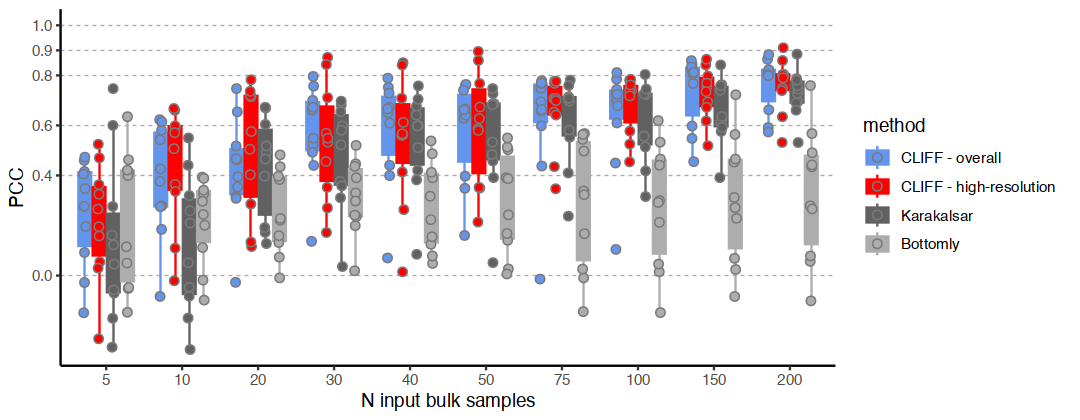

In [230]:
options(repr.plot.width=9, repr.plot.height=3.5)
g <- ggplot(cor_m, aes(x=sample, y=value, fill=method)) + 
    geom_hline(yintercept=c(0,0.4,0.6,0.8,0.9,1.0), color='grey68', size=0.3, linetype='dashed') + #geom_hline(yintercept=20) +
    geom_boxplot(outlier.shape = NA, aes(color=method)) + 
    geom_point(shape = 21, position = position_jitterdodge(jitter.width = 0.1), color='grey48', stroke=0.5, size=2) +
    scale_fill_manual(values = c('cornflowerblue', 'red', 'grey38', 'grey68')) +
    scale_color_manual(values = c('cornflowerblue', 'red', 'grey38', 'grey68')) +
    scale_y_continuous(breaks = c(-0.5, 0, 0.4, 0.6, 0.8, 0.9, 1.0)) + ylab('PCC') +
    xlab('N input bulk samples') + theme_classic()
pdf('results/fig5/boxplot_10simulationAML_N_bulks_4methods_2.pdf', width=11, height=4) ; g ; dev.off()
g